# Multi variate time series modelling using LSTM

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf 
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv")

In [5]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


Attribute Information:

date time year-month-day hour:minute:second
Appliances, energy use in Wh
lights, energy use of light fixtures in the house in Wh
T1, Temperature in kitchen area, in Celsius
RH_1, Humidity in kitchen area, in %
T2, Temperature in living room area, in Celsius
RH_2, Humidity in living room area, in %
T3, Temperature in laundry room area
RH_3, Humidity in laundry room area, in %
T4, Temperature in office room, in Celsius
RH_4, Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH_5, Humidity in bathroom, in %
T6, Temperature outside the building (north side), in Celsius
RH_6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH_7, Humidity in ironing room, in %
T8, Temperature in teenager room 2, in Celsius
RH_8, Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH_9, Humidity in parents room, in %
To, Temperature outside (from Chievres weather station), in Celsius
Pressure (from Chievres weather station), in mm Hg
RH_out, Humidity outside (from Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional

In [6]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

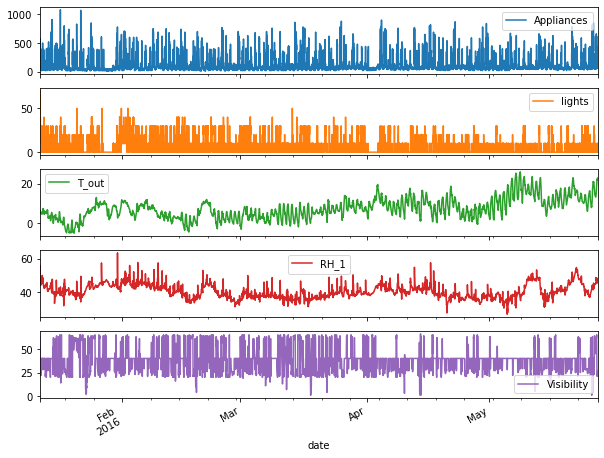

In [7]:
df.set_index('date')[['Appliances', 'lights','T_out', 'RH_1', 'Visibility']].plot(subplots=True)

In [8]:
df_input=df[['Appliances','T_out', 'RH_1', 'Visibility']]

# Scaling

In [9]:
scaler = MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)

In [10]:
data_scaled

array([[0.04672897, 0.37299035, 0.56618659, 0.95384615],
       [0.04672897, 0.36923901, 0.54132648, 0.89487179],
       [0.03738318, 0.36548767, 0.53050179, 0.83589744],
       ...,
       [0.24299065, 0.88317256, 0.53866618, 0.37435897],
       [0.38317757, 0.87888532, 0.54949087, 0.38717949],
       [0.39252336, 0.87459807, 0.53875791, 0.4       ]])

In [11]:
features = data_scaled
target = data_scaled[:,0]

In [12]:
TimeseriesGenerator(features,target,length=2,sampling_rate=1,batch_size=1)[0]

(array([[[0.04672897, 0.37299035, 0.56618659, 0.95384615],
         [0.04672897, 0.36923901, 0.54132648, 0.89487179]]]),
 array([0.03738318]))

# Train test split

In [13]:
xtrain,xtest,ytrain,ytest=train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)

**shuffle=False is an important parameter while doing time series. As the values do not shuffle during the training process for sequence modelling.**

In [14]:
xtrain.shape

(15788, 4)

In [15]:
xtest.shape

(3947, 4)

In [16]:
ytrain.shape

(15788,)

In [17]:
win_length=720
batch_size=32
num_features=4
train_generator = TimeseriesGenerator(xtrain, ytrain, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(xtest, ytest, length=win_length, sampling_rate=1, batch_size=batch_size)

In [18]:
train_generator[0]

(array([[[0.04672897, 0.37299035, 0.56618659, 0.95384615],
         [0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         ...,
         [0.06542056, 0.25241158, 0.31584258, 0.79230769],
         [0.05607477, 0.23901393, 0.31309054, 0.72820513],
         [0.06542056, 0.22561629, 0.31107238, 0.66410256]],
 
        [[0.04672897, 0.36923901, 0.54132648, 0.89487179],
         [0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         ...,
         [0.05607477, 0.23901393, 0.31309054, 0.72820513],
         [0.06542056, 0.22561629, 0.31107238, 0.66410256],
         [0.06542056, 0.21221865, 0.30923768, 0.6       ]],
 
        [[0.03738318, 0.36548767, 0.53050179, 0.83589744],
         [0.03738318, 0.36173633, 0.52408036, 0.77692308],
         [0.04672897, 0.35798499, 0.53141914, 0.71794872],
         ...,
         [0.06542056, 0.22561629, 0.31107238, 0.66410256],
        

# Model - LSTM neural network

In [19]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(128,input_shape=(win_length,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(1))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 128)          68096     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 720, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 128)          131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 720, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 720, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

In [22]:
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [23]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    shuffle=False,
    callbacks = [early_stopping]
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
471/471 [==============================] - 54s 102ms/step - loss: 0.0117 - mean_absolute_error: 0.0624 - val_loss: 0.0057 - val_mean_absolute_error: 0.0465
Epoch 2/50
471/471 [==============================] - 47s 99ms/step - loss: 0.0086 - mean_absolute_error: 0.0500 - val_loss: 0.0045 - val_mean_absolute_error: 0.0371
Epoch 3/50
471/471 [==============================] - 47s 100ms/step - loss: 0.0062 - mean_absolute_error: 0.0409 - val_loss: 0.0034 - val_mean_absolute_error: 0.0301
Epoch 4/50
471/471 [==============================] - 47s 99ms/step - loss: 0.0049 - mean_absolute_error: 0.0353 - val_loss: 0.0032 - val_mean_absolute_error: 0.0264
Epoch 5/50
471/471 [==============================] - 47s 99ms/step - loss: 0.0048 - mean_absolute_error: 0.0341 - val_loss: 0.0032 - val_mean_absolute_error: 0.0281
Epoch 6/50
471/471 [==============================] - 47s 100ms/step - loss: 0.0047 - mean_absolute_error: 0.0337 - val_loss: 0.0032 - val_mean_absolute_error: 0.0265
E

In [24]:
model.evaluate_generator(test_generator,verbose=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0031872170511633158, 0.027589520439505577]

In [25]:
predictions = model.predict_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
predictions.shape

(3227, 1)

In [27]:
predictions

array([[0.07288666],
       [0.09226146],
       [0.1168278 ],
       ...,
       [0.08678348],
       [0.25096107],
       [0.27163744]], dtype=float32)

In [28]:
ytest

array([0.3364486 , 0.54205607, 0.28971963, ..., 0.24299065, 0.38317757,
       0.39252336])

In [29]:
xtest

array([[0.3364486 , 0.34297964, 0.30923768, 0.6       ],
       [0.54205607, 0.34726688, 0.3055683 , 0.6       ],
       [0.28971963, 0.35155413, 0.30455921, 0.6       ],
       ...,
       [0.24299065, 0.88317256, 0.53866618, 0.37435897],
       [0.38317757, 0.87888532, 0.54949087, 0.38717949],
       [0.39252336, 0.87459807, 0.53875791, 0.4       ]])

In [30]:
xtest.shape

(3947, 4)

In [31]:
xtest[:,1:][win_length:]

array([[0.45337621, 0.20851298, 0.6       ],
       [0.47106109, 0.18282726, 0.6       ],
       [0.48874598, 0.18466196, 0.6       ],
       ...,
       [0.88317256, 0.53866618, 0.37435897],
       [0.87888532, 0.54949087, 0.38717949],
       [0.87459807, 0.53875791, 0.4       ]])

In [32]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(xtest[:,1:][win_length:])],axis=1)

In [33]:
df_pred

,0,0,1,2
0,0.072887,0.453376,0.208513,0.600000
1,0.092261,0.471061,0.182827,0.600000
2,0.116828,0.488746,0.184662,0.600000
3,0.337485,0.506431,0.193996,0.600000
4,0.151413,0.524116,0.181818,0.600000
...,...,...,...,...
3222,0.085135,0.891747,0.537657,0.348718
3223,0.098966,0.887460,0.536006,0.361538
3224,0.086783,0.883173,0.538666,0.374359
3225,0.250961,0.878885,0.549491,0.387179


In [34]:
rev_trans=scaler.inverse_transform(df_pred)

In [35]:
rev_trans

array([[ 87.98872694,   9.1       ,  34.6       ,  40.        ],
       [108.71976584,   9.65      ,  33.66666667,  40.        ],
       [135.00574693,  10.2       ,  33.73333333,  40.        ],
       ...,
       [102.85832748,  22.46666667,  46.59666667,  25.33333333],
       [278.52833986,  22.33333333,  46.99      ,  26.16666667],
       [300.65206051,  22.2       ,  46.6       ,  27.        ]])

In [36]:
df_final=df_input[predictions.shape[0]*-1:]

In [37]:
df_final.count()

Appliances    3227
T_out         3227
RH_1          3227
Visibility    3227
dtype: int64

In [38]:
df_final=df_input[predictions.shape[0]*-1:]

In [39]:
df_final.count()

Appliances    3227
T_out         3227
RH_1          3227
Visibility    3227
dtype: int64

In [40]:
df_final['App_Pred']=rev_trans[:,0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_final

,Appliances,T_out,RH_1,Visibility,App_Pred
16508,90,9.100000,34.600000,40.000000,87.988727
16509,120,9.650000,33.666667,40.000000,108.719766
16510,390,10.200000,33.733333,40.000000,135.005747
16511,240,10.750000,34.072500,40.000000,371.108871
16512,120,11.300000,33.630000,40.000000,172.012334
...,...,...,...,...,...
19730,100,22.733333,46.560000,23.666667,101.094623
19731,90,22.600000,46.500000,24.500000,115.894125
19732,270,22.466667,46.596667,25.333333,102.858327
19733,420,22.333333,46.990000,26.166667,278.528340


<AxesSubplot:>

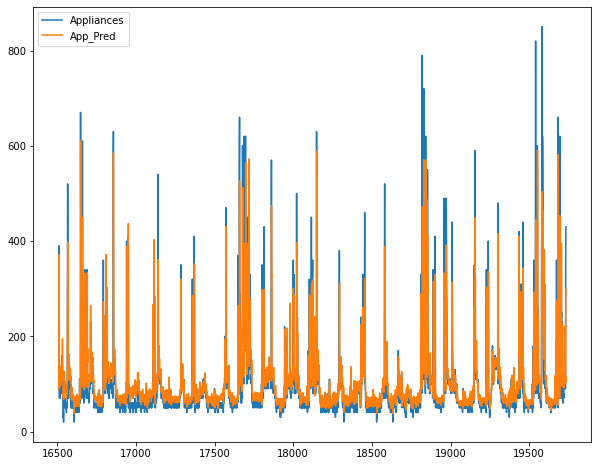

In [42]:
df_final[['Appliances','App_Pred']].plot()